<a href="https://colab.research.google.com/github/rajeshsurya59/Offensive-Language-Detection-BERT/blob/main/Offensive_Language_Detection_using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.0/110.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.9 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.28.0 which is incompatible.


In [3]:
# Mounting Google Drive - Only for Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#============================ Loading required libraries ============================#

import warnings
warnings.filterwarnings("ignore")

#!pip install datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import tensorflow as tf
import torch
from torch.utils.data import DataLoader, Dataset

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re

from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
#============================ Loading the dataset ============================#

#df = pd.read_csv('/content/drive/MyDrive/hate_offensive_data.csv')
df = pd.read_csv('/content/drive/MyDrive/text/hate_offensive_data.csv')
del df['Unnamed: 0']

df['label'] = np.where(df['class']==2, 0, 1)

# Class 0 - Appropriate (Safe)
# Class 1 - Inappropriate (Hateful or offensive)

df.head()

,count,hate_speech,offensive_language,neither,class,tweet,label
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [6]:
#============================ Text Preprocessing ============================#

stop_words = set(stopwords.words('english'))
stop_words.add("rt") # adding rt to remove retweet in dataset

# Removing Emojis
def strip_entities(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

# Replacing user tags
def remove_mentions(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "", raw_text)
    return text

# Removing URLs
def remove_urls(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)
    return text

# Removing Unnecessary Symbols
def clean_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')
    text = text.replace(".", '')
    text = text.replace(",", '')
    text = text.replace("#", '')
    text = text.replace(":", '')
    text = text.replace("?", '')
    return text

# Stemming
def stemming(raw_text):
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in raw_text.split()]
    return ' '.join(words)

# Removing stopwords
def filter_stopwords(raw_text):
    tokenize = word_tokenize(raw_text)
    text = [word for word in tokenize if not word.lower() in stop_words]
    text = ' '.join(text)
    return text

def preprocess(data):
    clean = []
    clean = [text.lower() for text in data]
    clean = [remove_mentions(text) for text in clean]
    clean = [strip_entities(text) for text in clean]
    clean = [remove_urls(text) for text in clean]
    clean = [clean_symbols(text) for text in clean]
    clean = [stemming(text) for text in clean]
    clean = [filter_stopwords(text) for text in clean]

    return clean

nltk.download('punkt_tab') # Download the missing NLTK resource

tweets = list(df['tweet'])
labels = list(df['label'])
clean_tweets = preprocess(tweets)

df_tweet = pd.DataFrame({'tweet': tweets, 'clean_tweet': clean_tweets, 'label': labels})

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [7]:
#============================ Read Preprocessed Data ============================#

#df = pd.read_csv('/content/drive/MyDrive/preprocessed_data.csv')
df = pd.read_csv('/content/drive/MyDrive/text/preprocessed_data.csv')
df['clean_tweet'] = df['clean_tweet'].astype(str)
df['tweet'] = df['tweet'].astype(str)

tweets = list(df['tweet'])
clean_tweets = list(df['clean_tweet'])
labels = list(df['label'])

df

,tweet,clean_tweet,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,woman shouldnt complain clean hous man alway t...,0
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dat coldtyga dwn bad cuffin dat hoe 1st place,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cri confus shit,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranni,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya,1
...,...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,muthaf * * * lie right hi tl trash mine bibl s...,1
24779,"you've gone and broke the wrong heart baby, an...",youv gone broke wrong heart babi drove redneck...,0
24780,young buck wanna eat!!.. dat nigguh like I ain...,young buck wan na eat dat nigguh like aint fuc...,1
24781,youu got wild bitches tellin you lies,youu got wild bitch tellin lie,1


In [8]:
df_tweet

,tweet,clean_tweet,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,woman shouldnt complain clean hous man alway t...,0
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dat coldtyga dwn bad cuffin dat hoe 1st place,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cri confus shit,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranni,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya,1
...,...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,muthaf * * * lie right hi tl trash mine bibl s...,1
24779,"you've gone and broke the wrong heart baby, an...",youv gone broke wrong heart babi drove redneck...,0
24780,young buck wanna eat!!.. dat nigguh like I ain...,young buck wan na eat dat nigguh like aint fuc...,1
24781,youu got wild bitches tellin you lies,youu got wild bitch tellin lie,1


In [9]:
df_tweet['label'].value_counts()
# Class 0 - Appropriate (Safe)
# Class 1 - Inappropriate (Hateful or offensive)

,count
label,
1,20620
0,4163


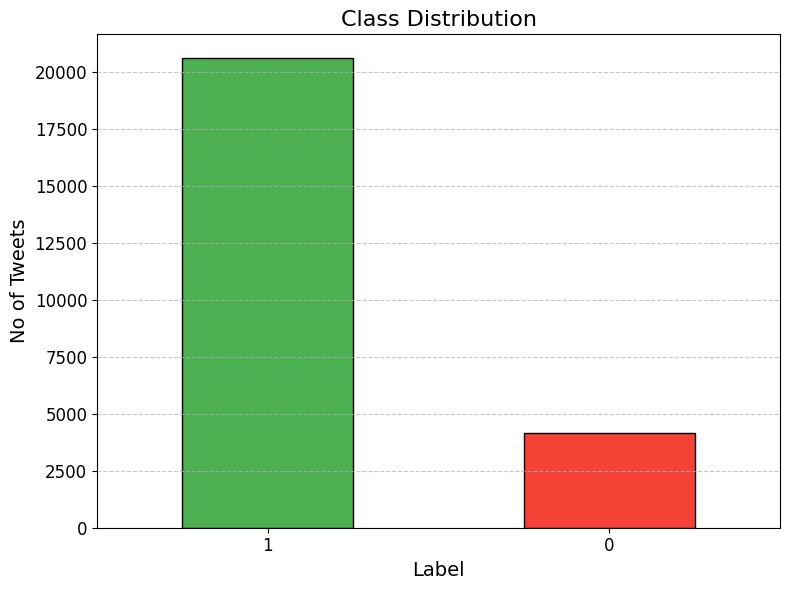

In [10]:

class_distribution = df_tweet['label'].value_counts()
plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar', color=['#4CAF50', '#F44336'], edgecolor='black')
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('No of Tweets', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines to y-axis with dashed style
plt.tight_layout()
plt.show()

In [11]:
#============================ Tokenization ============================#

# Split into training, validation and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(clean_tweets, labels, test_size=0.2, random_state=42)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

# Loading pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
#============================ Defining a PyTorch Dataset ============================#

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

In [13]:
#============================ Loading the pre-trained Model ============================#

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Defining optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Defining data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Training loop
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [14]:
from tqdm.auto import tqdm

for epoch in range(3):
    model.train()
    # Wrap the train_loader with tqdm for a progress bar
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    val_accuracy = 0
    # Wrap the val_loader with tqdm for a progress bar
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validating Epoch {epoch + 1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)
            val_accuracy += torch.sum(predictions == labels).item() / labels.size(0)

    avg_val_accuracy = val_accuracy / len(val_loader)
    print(f'Epoch {epoch + 1}, Validation Accuracy: {avg_val_accuracy}')

Training Epoch 1:   0%|          | 0/1983 [00:00<?, ?it/s]

Validating Epoch 1:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 1, Validation Accuracy: 0.9634576612903226


Training Epoch 2:   0%|          | 0/1983 [00:00<?, ?it/s]

Validating Epoch 2:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 2, Validation Accuracy: 0.9624495967741935


Training Epoch 3:   0%|          | 0/1983 [00:00<?, ?it/s]

Validating Epoch 3:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 3, Validation Accuracy: 0.9647177419354839


In [20]:
#============================ Evaluating Model Performance ============================#

true_labels = []
predicted_labels = []

# Ensure model is on the correct device before evaluation
model.to(device)

# Evaluation loop
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

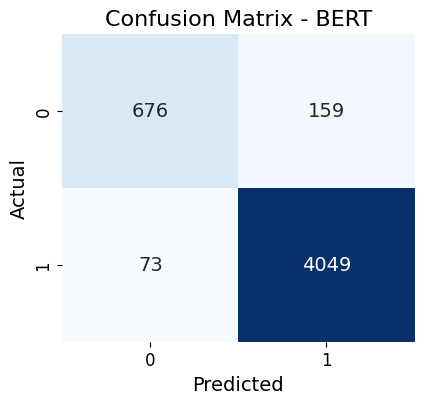


Classification Report:

                precision    recall  f1-score   support

  Appropriate       0.90      0.81      0.85       835
Inappropriate       0.96      0.98      0.97      4122

     accuracy                           0.95      4957
    macro avg       0.93      0.90      0.91      4957
 weighted avg       0.95      0.95      0.95      4957


Evaluation Metrics:

Accuracy: 0.9531974984869881
Precision: 0.9622148288973384
Recall: 0.9822901504124212
F1-score: 0.9721488595438176


In [21]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.title('Confusion Matrix - BERT', fontsize = 16)
plt.xlabel('Predicted', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


# Classification report
target_names = ['Appropriate', 'Inappropriate']
print('\nClassification Report:\n\n', classification_report(true_labels, predicted_labels, target_names=target_names))

# Evaluation Metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
print("\nEvaluation Metrics:\n")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

In [14]:
#============================ Save the  model ============================#

# model.save_pretrained('/content/drive/MyDrive/text/bert_model/')
# model.save_pretrained('/bert_model/')

In [22]:
#============================ Prediction ============================#

import torch
from transformers import BertForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification

#Text Preprocessing

stop_words = set(stopwords.words('english'))
stop_words.add("rt") # adding rt to remove retweet in dataset

# Removing Emojis
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

# Replacing user tags
def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "", raw_text)
    return text

# Removing URLs
def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)
    return text

# Removing Unnecessary Symbols
def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')
    text = text.replace(".", '')
    text = text.replace(",", '')
    text = text.replace("#", '')
    text = text.replace(":", '')
    text = text.replace("?", '')
    return text

# Stemming
def stemming(raw_text):
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in raw_text.split()]
    return ' '.join(words)

# Removing stopwords
def remove_stopwords(raw_text):
    tokenize = word_tokenize(raw_text)
    text = [word for word in tokenize if not word.lower() in stop_words]
    text = ' '.join(text)
    return text

def preprocess(data):
    clean = []
    clean = [text.lower() for text in data]
    clean = [change_user(text) for text in clean]
    clean = [remove_entity(text) for text in clean]
    clean = [remove_url(text) for text in clean]
    clean = [remove_noise_symbols(text) for text in clean]
    clean = [stemming(text) for text in clean]
    clean = [remove_stopwords(text) for text in clean]

    return clean

In [23]:
#============================ Load the saved model ============================#

from transformers import BertForSequenceClassification

loaded_model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/text/bert_model', local_files_only=True)

# You can now use loaded_model for predictions or further evaluation
print("Model loaded successfully!")

Model loaded successfully!


⚠️ Prediction: Inappropriate (Offensive)
Predicted Label: 1
Probability for Class 0 (Appropriate): 0.02454090490937233
Probability for Class 1 (Inappropriate): 0.975459098815918


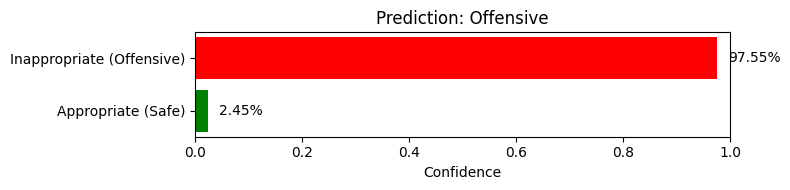

In [24]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import matplotlib.pyplot as plt

# Load model and tokenizer
model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/text/bert_model')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Your input
# custom_input_text = " now you're ready to vote for donald trump "

custom_input_text = "why the f**k"

# Optional: dummy preprocess function (replace if you have a custom one)
def preprocess(text_list):
    return text_list

custom_text_list = [custom_input_text]
preprocessed_custom_text = preprocess(custom_text_list)[0]

# Tokenization
tokenized_input = tokenizer(preprocessed_custom_text, return_tensors='pt')

# Prediction
model.eval()
with torch.no_grad():
    output = model(**tokenized_input)
    logits = output.logits
    probabilities = torch.softmax(logits, dim=1)

predicted_label = torch.argmax(probabilities, dim=1).item()
probability_class_0 = probabilities[0][0].item()
probability_class_1 = probabilities[0][1].item()
threshold = 0.4

if probability_class_1 >= threshold:
    print("⚠️ Prediction: Inappropriate (Offensive)")
else:
    print("✅ Prediction: Appropriate (Safe)")


# Print results
print("Predicted Label:", predicted_label)
print("Probability for Class 0 (Appropriate):", probability_class_0)
print("Probability for Class 1 (Inappropriate):", probability_class_1)

# ========================= 📊 Show Probability Bar Chart ========================= #
classes = ['Appropriate (Safe)', 'Inappropriate (Offensive)']
probs = [probability_class_0, probability_class_1]

plt.figure(figsize=(8, 2))
bars = plt.barh(classes, probs, color=['green', 'red'])
plt.xlim(0, 1)
plt.xlabel("Confidence")
plt.title(f"Prediction: {'Safe' if predicted_label == 0 else 'Offensive'}")

# Decide final prediction label based on threshold
threshold = 0.4
final_prediction = "Offensive" if probability_class_1 >= threshold else "Safe"

plt.title(f"Prediction: {final_prediction}")


# Add text on bars
for bar in bars:
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
             f"{bar.get_width()*100:.2f}%", va='center')

plt.tight_layout()
plt.show()
